In [ ]:
!pip install evaluate
!pip install datasets
!pip install fsspec==2023.9.2


In [ ]:
#from google.colab import drive
from datasets import DatasetDict, ClassLabel, Dataset, load_dataset
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import (
  AutoConfig,
  AutoTokenizer,
  AutoModelForSequenceClassification ## capa de clasificación
)
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
from datasets import DatasetDict, ClassLabel
import pandas as pd
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
#drive.mount('/content/drive')

In [ ]:
ruta = 'data_for_trainning_encoder.parquet'
#ruta = '/content/drive/My Drive/TFM/data_for_trainning_encoder.parquet'

df = pd.read_parquet(ruta)
df


###subset aleatorio pero manteniendo proporcion de busqueda mercadona-hacendado
n = 4308
df['sentimiento_producto'] =df['sentimiento_producto'].astype(str).str.strip()
df_balanceado = (df.groupby('sentimiento_producto', group_keys=False).apply(lambda x: x.sample(n=n//2, random_state=69)))

df = df_balanceado


/tmp/ipython-input-882625085.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanceado = (df.groupby('sentimiento_producto', group_keys=False).apply(lambda x: x.sample(n=n//2, random_state=69)))


In [ ]:
df.columns

Index(['index', 'User', 'tweets', 'search', 'fecha_captura',
       'explica_sentimiento', 'explica_sentimiento_2', 'sentimiento_final',
       'proteccion_datos', 'deteccion_producto', 'producto',
       'sentimiento_producto', 'categoria', 'comparativa_producto',
       'comparativa_sentimiento', 'imagen_marca'],
      dtype='object')

In [ ]:
df['comparativa_producto'].value_counts()

,count
comparativa_producto,
No aplica,2154
NO,1553
SI,601


In [ ]:
### filtrar y balancear datos

df = pd.read_parquet(ruta)
df['comparativa_producto'] = df['comparativa_producto'].astype(str).str.strip()
df = df[(df['comparativa_producto'] == "SI") | (df['comparativa_producto'] == "NO")]


n = 1202
df['sentimiento_producto'] =df['comparativa_producto'].astype(str).str.strip()
df_balanceado = (df.groupby('comparativa_producto', group_keys=False).apply(lambda x: x.sample(n=n//2, random_state=69)))
df = df_balanceado

# Contar los valores
df['comparativa_producto'].value_counts()

/tmp/ipython-input-547154709.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanceado = (df.groupby('comparativa_producto', group_keys=False).apply(lambda x: x.sample(n=n//2, random_state=69)))


,count
comparativa_producto,
NO,601
SI,601


In [ ]:
nombre_modelo_nuevo= 'comparativa_producto_detection'

In [ ]:
df_for_training = df[['tweets', 'comparativa_producto']].copy()

df_for_training = df_for_training.rename(columns={'tweets': 'text', 'comparativa_producto':'labels' })
df_for_training['labels'] = (df_for_training['labels']
                              .astype(str)
                              .str.strip()
                              .str.upper()
                              .map({'SI': 1, 'NO': 0}))
df_for_training

,text,labels
6969,"de tanto ver memes del helado ""polvito"" del me...",0
7850,Hago un llamamiento a mercadona para que vuelv...,0
2854,"Rubiales, el Lex Luthor de Hacendado que nos m...",0
1427,los sobres de pasta del hacendado???? estan BU...,0
3346,Deliplus Hacendado Arena. Ese sí hubiera estad...,0
...,...,...
9232,Chocolates do mercadona >>>,1
5714,Ver Walking dead y darte cuenta de que los zom...,1
6675,"No, a ver, no solo el Listerine autentico, el ...",1
2680,Los bombones de Hacendado imitación de los Fer...,1


In [ ]:
dataset = Dataset.from_pandas(df_for_training)
dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 1202
})

In [ ]:
model_name = 'microsoft/mdeberta-v3-base' #"EuroBERT/EuroBERT-210m" #"BSC-LT/roberta-large-bne"   #base  #'microsoft/mdeberta-v3-base'

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False ) #use_fast=False en modelos Plant-TL



def preprocess_function(examples):
    # Tokenizar el texto

    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256) ##maxlen recomendado en deberta. No poner en resto si no da avisos

    #return tokenizer(examples['text'], padding="max_length", truncation=True)



dataset = dataset.map(preprocess_function, batched=True) # preprocess_function


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1202 [00:00<?, ? examples/s]

In [ ]:
# 1. División inicial: 90% train+dev, 10% test
split_1 = dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)

# 2. División secundaria: de ese 90%, separamos 11.11% para validación → (10% del total original)
split_2 = split_1['train'].train_test_split(test_size=0.1111, shuffle=True, seed=69)

# 3. Armamos todo en un DatasetDict
final_splits = DatasetDict({
    'train': split_2['train'],
    'validation': split_2['test'],
    'test': split_1['test']
})

# 4. Verificación de tamaños
print(f"Train: {len(final_splits['train'])}")
print(f"Validation: {len(final_splits['validation'])}")
print(f"Test: {len(final_splits['test'])}")

Train: 960
Validation: 121
Test: 121


In [ ]:
from collections import Counter

def print_label_distribution(split_name, dataset):
    labels = dataset['labels']
    total = len(labels)
    counter = Counter(labels)
    print(f"Distribución en {split_name} (total {total}):")
    for label, count in counter.items():
        print(f"  Clase {label}: {count} ({count/total:.2%})")
    print()

# Asumiendo que tienes final_splits como DatasetDict
print_label_distribution('Train', final_splits['train'])
print_label_distribution('Validation', final_splits['validation'])
print_label_distribution('Test', final_splits['test'])

Distribución en Train (total 960):
  Clase 1: 470 (48.96%)
  Clase 0: 490 (51.04%)

Distribución en Validation (total 121):
  Clase 1: 66 (54.55%)
  Clase 0: 55 (45.45%)

Distribución en Test (total 121):
  Clase 0: 56 (46.28%)
  Clase 1: 65 (53.72%)



In [ ]:
dataset = final_splits

In [ ]:
### modelo.

In [ ]:
SEED = 69

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)



id2label = {0: "NO", 1: "SI"}
label2id = {"NO": 0, "SI": 1}



def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",


    trust_remote_code=True,
    #hiden modelo eurobert
    # hidden_dropout=0.1,
    # attention_dropout=0.1,

    #hiden modelo roberta
    # para hacer dropout al modelo.

    #hidden_dropout_prob=0.1,  # dropout en capas ocultas cuando se activa afecta a la cabeza de clasificacion
    #attention_probs_dropout_prob=0.1,  # dropout en atención

    #classifier_dropout=0.3,     # dropout en clasificación para ajustar solamente la cabeza.

    )

model = model_init()
print(model.config)


# # imprimir layers entrenables
for name, param in model.named_parameters():
  print(name, param.requires_grad)

print(100*("="))
print('dropout')
# Verificar  dropout
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Dropout):
        print(f"{name}: {module}")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2Config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NO",
    "1": "SI"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NO": 0,
    "SI": 1
  },
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "torch_dtype": "float32",
  "transformers_version": "4.55.2",
  "type_vocab_size": 0,
  "vocab_size": 251000
}

deberta.embeddings.word_embeddings.weight True
deberta.embeddings.LayerNorm.weight True
deberta.embeddin

In [ ]:
#NO-MODIFY: VARIABLE NAME
training_args =  TrainingArguments(
    output_dir=nombre_modelo_nuevo,
    learning_rate= 4e-05 ,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs= 15,
    weight_decay=0.1,
    eval_strategy="steps",
    #save_strategy="steps",
    save_strategy="best",
    save_total_limit=3,
    eval_steps=10, #50,
    logging_strategy="steps",
    logging_steps=10, #50,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    seed=SEED,
    metric_for_best_model="f1_score",
    greater_is_better=True,
    #bf16=True, #
    full_determinism=True,
    gradient_accumulation_steps=8 #

)

In [ ]:
accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)["f1"]

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }

/tmp/ipython-input-714299730.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1 Score
10,0.672600,0.629140,0.628099,0.671533
20,0.548400,0.531783,0.760331,0.797203
30,0.407400,0.578158,0.760331,0.764228
40,0.249900,0.765146,0.719008,0.706897
50,0.153400,0.793042,0.743802,0.755906


{'eval_loss': 0.7930418252944946, 'eval_accuracy': 0.743801652892562, 'eval_f1_score': 0.7559055118110236, 'eval_runtime': 2.3221, 'eval_samples_per_second': 52.108, 'eval_steps_per_second': 3.445, 'epoch': 6.266666666666667}


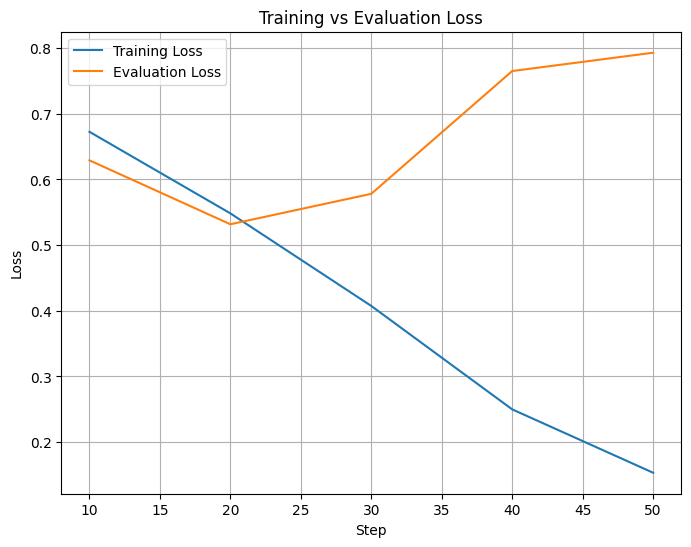

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= dataset['train'],
    eval_dataset= dataset['validation'],
    tokenizer=tokenizer ,
    compute_metrics= compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] #
)



trainer.train()
metrics = trainer.evaluate()
print(metrics)


# Extraemos los logs de entrenamiento
history = pd.DataFrame(trainer.state.log_history)

# A veces los logs pueden tener pasos donde no se evalúa. Filtramos filas con 'loss' y 'eval_loss'
train_loss = history[history['loss'].notna()][['step', 'loss']]
eval_loss = history[history['eval_loss'].notna()][['step', 'eval_loss']]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss')
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Evaluation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.7930418252944946, 'eval_accuracy': 0.743801652892562, 'eval_f1_score': 0.7559055118110236, 'eval_runtime': 2.3191, 'eval_samples_per_second': 52.175, 'eval_steps_per_second': 3.45, 'epoch': 6.266666666666667}


In [ ]:
### estas son las metricas que estoy cogiendo.
trainer.evaluate(dataset['test'])

{'eval_loss': 0.6849710941314697,
 'eval_accuracy': 0.7933884297520661,
 'eval_f1_score': 0.7967479674796748,
 'eval_runtime': 2.334,
 'eval_samples_per_second': 51.843,
 'eval_steps_per_second': 3.428,
 'epoch': 6.266666666666667}

metricas
{'test_loss': 0.6849710941314697, 'test_accuracy': 0.7933884297520661, 'test_f1_score': 0.7967479674796748, 'test_runtime': 2.3291, 'test_samples_per_second': 51.951, 'test_steps_per_second': 3.435}
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79        56
           1       0.84      0.75      0.80        65

    accuracy                           0.79       121
   macro avg       0.80      0.80      0.79       121
weighted avg       0.80      0.79      0.79       121



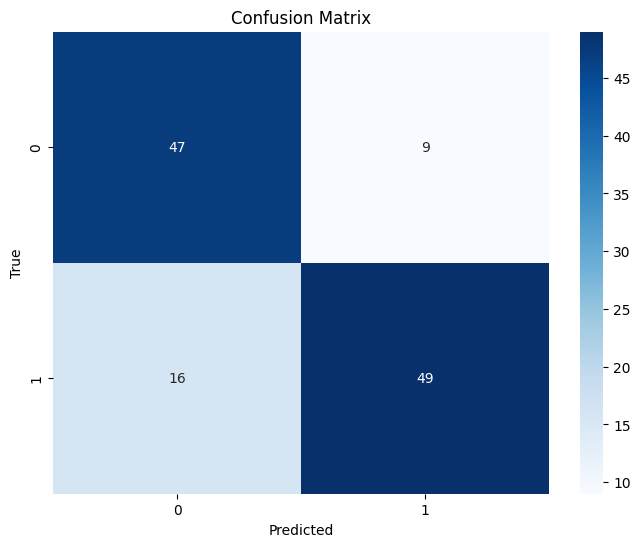

In [ ]:
### Crear una matriz de confusión
# Obtener predicciones
predicciones_trainer = trainer.predict(dataset['test'])

print("metricas")
print(predicciones_trainer.metrics)

# Las predicciones pueden venir como logits, necesitamos el argmax
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
# Etiquetas verdaderas
y_true = predicciones_trainer.label_ids
cm = confusion_matrix(y_true, y_pred)

# print("Confusion Matrix:")
# print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:



#4e5 16/16
#               precision    recall  f1-score   support

#            0       0.78      0.82      0.80        56
#            1       0.84      0.80      0.82        65

#     accuracy                           0.81       121
#    macro avg       0.81      0.81      0.81       121
# weighted avg       0.81      0.81      0.81       121

In [ ]:
# Predicción final (clase con mayor probabilidad)
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
y_true = predicciones_trainer.label_ids

# Obtener los textos originales
textos = dataset['test']['text']

# Crear un DataFrame para inspeccionar
df_resultados = pd.DataFrame({
    'texto': textos,
    'etiqueta_verdadera': y_true,
    'etiqueta_predicha': y_pred
})

falsos_positivos = df_resultados[(df_resultados.etiqueta_verdadera == 0) & (df_resultados.etiqueta_predicha == 1)]
falsos_negativos = df_resultados[(df_resultados.etiqueta_verdadera == 1) & (df_resultados.etiqueta_predicha == 0)]
falsos_negativos

,texto,etiqueta_verdadera,etiqueta_predicha
1,"Si os apetece comer nuggets de pollo, pillad l...",1,0
3,Las barritas de hacendado del Mercadona que im...,1,0
19,"Acabo de probar la Cola Zero de @Mercadona , l...",1,0
27,No puedo con la Beyonce de hacendado,1,0
32,Señores del Mercadona: el té chai lleva un toq...,1,0
37,La coca cola del @Mercadona esta to mala,1,0
49,El otro día pedí en un restaurante de Santiago...,1,0
55,Para mi el mercadona tiene un tipo de pollo qu...,1,0
58,Mañana comienza una nueva era.\n\nLa era del s...,1,0
61,por el hummus del mercadona mato.,1,0


In [ ]:
falsos_positivos

,texto,etiqueta_verdadera,etiqueta_predicha
0,Capricho de viernes: comerme un coulant de cho...,0,1
40,no compréis el café de Mercadona cada día sabe...,0,1
43,He pensado en un eslogan para los donuts de Ha...,0,1
56,lo meu però de hacendado,0,1
75,"Pues no os voy a engañar, voy a probar una fab...",0,1
79,Mi madre ha traído una bolsa gigante con chuch...,0,1
89,Han quitado las salchichas cocktail Dak del Me...,0,1
100,El tabulé oriental de hacendado está más boeno...,0,1
112,Me preocupa que los 6 últimos puntos+ el tapón...,0,1


In [ ]:
df

,index,User,tweets,search,fecha_captura,explica_sentimiento,explica_sentimiento_2,sentimiento_final,proteccion_datos,deteccion_producto,producto,sentimiento_producto,categoria,comparativa_producto,comparativa_sentimiento,imagen_marca
6969,201238,zzzzoldyck,"de tanto ver memes del helado ""polvito"" del me...",mercadona,2019-06-12,Sentimiento: positivo. Razón: El mensaje expre...,Sentimiento: positivo. Razón: El mensaje expre...,positivo,NO,SI,1: helado polvito,NO,1: Congelados : Helados \n,NO,No aplica,NO
7850,252897,Belsita,Hago un llamamiento a mercadona para que vuelv...,mercadona,2020-06-30,Sentimiento: negativo. Razón: El mensaje expre...,Sentimiento: negativo. Razón: El mensaje expre...,negativo,NO,SI,1: helado de galleta,NO,1: Congelados : Helados \n,NO,No aplica,NO
2854,328399,Darío Vilas Couselo,"Rubiales, el Lex Luthor de Hacendado que nos m...",hacendado,2023-08-26,Sentimiento: negativo. Razón: El mensaje utili...,Sentimiento: negativo. Razón: El mensaje utili...,negativo,NO,SI,1: Hacendado,NO,1: Indeterminado : Indeterminado \n,NO,No aplica,NO
1427,323169,carol⁷ ౨ৎ,los sobres de pasta del hacendado???? estan BU...,hacendado,2024-03-15,Sentimiento: positivo. Razón: El mensaje expre...,Sentimiento: positivo. Razón: El mensaje expre...,positivo,NO,SI,1: sobres de pasta 2: pasta,NO,"1: Arroz, legumbres y pasta : Pasta y fideos\n...",NO,No aplica,NO
3346,323313,Dani #LimGoHome,Deliplus Hacendado Arena. Ese sí hubiera estad...,hacendado,2020-06-30,Sentimiento: negativo. Razón: El mensaje expre...,Sentimiento: negativo. Razón: El mensaje expre...,negativo,NO,SI,1: Deliplus Hacendado Arena,NO,1: Indeterminado : Indeterminado \n,NO,No aplica,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9232,141426,𝕄𝕒𝕣𝕚𝕒 𝔽𝕣𝕒𝕟𝕔𝕚𝕤𝕔𝕒,Chocolates do mercadona >>>,mercadona,2022-03-09,Sentimiento: positivo. Razón: El mensaje expre...,Sentimiento: positivo. Razón: El mensaje expre...,positivo,NO,SI,1: Chocolates,SI,"1: Azúcar, caramelos y chocolate : Chocolate \n",SI,Chocolates de mercadona : positivo,SI
5714,86791,Peqeneque,Ver Walking dead y darte cuenta de que los zom...,mercadona,2015-10-18,Sentimiento: negativo. Razón: El mensaje expre...,Sentimiento: negativo. Razón: El mensaje expre...,negativo,NO,SI,1: vodka,SI,1: Bodega : Licores \n,SI,vodka del mercadona : negativo,SI
6675,247060,wazelig,"No, a ver, no solo el Listerine autentico, el ...",mercadona,2020-10-07,Sentimiento: negativo. Razón: El mensaje expre...,Sentimiento: negativo. Razón: El mensaje expre...,negativo,NO,SI,1: Listerine 2: marca blanca 3: Listerine aute...,SI,1: Cuidado facial y corporal : Higiene bucal\n...,SI,Producto de marca blanca del Mercadona : negat...,NO
2680,325226,sergio,Los bombones de Hacendado imitación de los Fer...,hacendado,2020-11-06,Sentimiento: positivo. Razón: El mensaje expre...,Sentimiento: positivo. Razón: El mensaje expre...,positivo,NO,SI,1: bombones 2: Ferrero Rocher,SI,"1: Azúcar, caramelos y chocolate : Chocolate\n...",SI,Bombones de Hacendado : positivo,NO


In [ ]:
# Ruta al checkpoint que quieres cargar
best_checkpoint_path = "comparativa_producto_detection/checkpoint-20" #eurobert 140

# Cargar el modelo desde el checkpoint
model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint_path)

# Volver a crear el Trainer con el modelo cargado
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= dataset['train'],
    eval_dataset= dataset['validation'],
    compute_metrics=compute_metrics
)

# Evaluar
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.5317834615707397, 'eval_model_preparation_time': 0.0029, 'eval_accuracy': 0.7603305785123967, 'eval_f1_score': 0.7972027972027972, 'eval_runtime': 2.3701, 'eval_samples_per_second': 51.052, 'eval_steps_per_second': 3.375}


In [ ]:
### estas son las metricas que estoy cogiendo.
trainer.evaluate(dataset['test'])


{'eval_loss': 0.455864280462265,
 'eval_model_preparation_time': 0.0029,
 'eval_accuracy': 0.8264462809917356,
 'eval_f1_score': 0.8489208633093526,
 'eval_runtime': 2.311,
 'eval_samples_per_second': 52.357,
 'eval_steps_per_second': 3.462}

metricas
{'test_loss': 0.455864280462265, 'test_model_preparation_time': 0.0029, 'test_accuracy': 0.8264462809917356, 'test_f1_score': 0.8489208633093526, 'test_runtime': 2.3401, 'test_samples_per_second': 51.707, 'test_steps_per_second': 3.419}
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.73      0.80        56
           1       0.80      0.91      0.85        65

    accuracy                           0.83       121
   macro avg       0.83      0.82      0.82       121
weighted avg       0.83      0.83      0.82       121



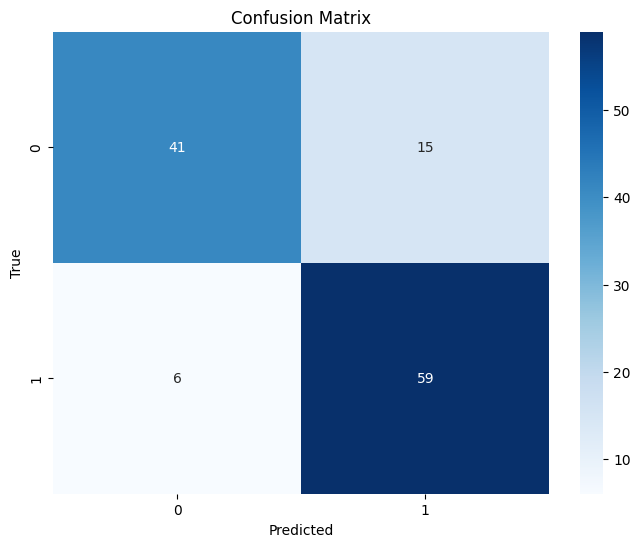

In [ ]:
### Crear una matriz de confusión
# Obtener predicciones
predicciones_trainer = trainer.predict(dataset['test'])

print("metricas")
print(predicciones_trainer.metrics)

# Las predicciones pueden venir como logits, necesitamos el argmax
y_pred = np.argmax(predicciones_trainer.predictions, axis=1)
# Etiquetas verdaderas
y_true = predicciones_trainer.label_ids
cm = confusion_matrix(y_true, y_pred)

# print("Confusion Matrix:")
# print(cm)

print("Classification Report:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
from huggingface_hub import login
login(token='')
# trainer.push_to_hub()